Problem 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.
At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.
One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.
Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.
In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''

In [2]:
# Creating character vocabulary
# part of the data preprocessing step for a character-level text modeling task. 
# Create mappings between characters in the text and numerical indices

#set(text): Creates a set of unique characters found in the text. The set function removes any duplicate characters.
#list(set(text)): Converts the set back into a list so that it can be sorted. 
# sorted(list(set(text))): Sorts the list of unique characters. 
chars = sorted(list(set(text)))
#This line creates a dictionary that maps each character to a unique index (integer)."
ix_to_char = {i: ch for i, ch in enumerate(chars)}
#Similar to the previous line, but in reverse. This line creates a dictionary that maps each unique index (integer) back to its corresponding character.
char_to_ix = {ch: i for i, ch in enumerate(chars)} 
chars = sorted(list(set(text)))

# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

In [3]:
import torch.nn as nn

# Defining the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [4]:
# Defining the LSTM model
class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size 
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [5]:
# Defining the GRU model
class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output 

In [6]:
def train(model, epochs, optimizer, criterion, X_train, y_train, X_val, y_val):
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()
    initial_start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy.item())

        if epoch % 10 == 0:
            end_time = time.time()
            print(f'Epoch [{epoch}/{epochs}], '
                  f'Training Loss: {loss.item():.4f}, '
                  f'Validation Loss: {val_loss.item():.4f}, '
                  f'Validation Accuracy: {val_accuracy.item()*100:.2f}%'
                  f', Time per 10 epochs: {end_time - start_time:.2f}s')
            start_time = time.time()
    final_end_time = time.time()
    total_train_time = final_end_time - initial_start_time
    print("=======================================================================================================================")
    return train_losses, val_losses, val_accuracies, total_train_time

In [7]:
# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

In [8]:
# Hyperparameters
hidden_size = 1024
learning_rate = 0.005
epochs = 100

# Model Definitions
RNN_model = CharRNN(len(chars), hidden_size, len(chars)).to(device)
LSTM_model = CharLSTM(len(chars), hidden_size, len(chars)).to(device)
GRU_model = CharGRU(len(chars), hidden_size, len(chars)).to(device)
criterion = nn.CrossEntropyLoss()

stats_RNN =summary(
    RNN_model,
    (max_length, len(chars)),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    device=device,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

stats_LSTM =summary(
    LSTM_model,
    (max_length, len(chars)),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    device=device,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

stats_GRU =summary(
    GRU_model,
    (max_length, len(chars)),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    device=device,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)


#Optimizers
RNN_optimizer = optim.Adam(RNN_model.parameters(), lr=learning_rate)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)
GRU_optimizer = optim.Adam(GRU_model.parameters(), lr=learning_rate)

RNN_train_loss, RNN_val_loss, RNN_val_acc, RNN_time = train(RNN_model, epochs, RNN_optimizer, criterion, X_train, y_train, X_val, y_val)
LSTM_train_loss, LSTM_val_loss, LSTM_val_acc, LSTM_time = train(LSTM_model, epochs, LSTM_optimizer, criterion, X_train, y_train, X_val, y_val)
GRU_train_loss, GRU_val_loss, GRU_val_acc, GRU_time = train(GRU_model, epochs, GRU_optimizer, criterion, X_train, y_train, X_val, y_val)

print(f'Total trainign time for RNN {RNN_time:.2f} s')
print(f'Total trainign time for LSTM {LSTM_time:.2f} s')
print(f'Total trainign time for GRU {GRU_time:.2f} s')

Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
CharRNN (CharRNN)                        --               [30, 45]         --               --
├─Embedding (embedding)                  --               [30, 45, 1024]   46,080           1,382,400
│    └─weight                            [1024, 45]                        └─46,080
├─RNN (rnn)                              --               [30, 45, 1024]   2,099,200        2,833,920,000
│    └─weight_ih_l0                      [1024, 1024]                      ├─1,048,576
│    └─weight_hh_l0                      [1024, 1024]                      ├─1,048,576
│    └─bias_ih_l0                        [1024]                            ├─1,024
│    └─bias_hh_l0                        [1024]                            └─1,024
├─Linear (fc)                            --               [30, 45]         46,125           1,383,750
│    └─weight                            [1024, 45]                  

In [9]:
test_str = " more sequence of text characte"
predicted_char = predict_next_char(RNN_model.to("cpu"), char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'r'


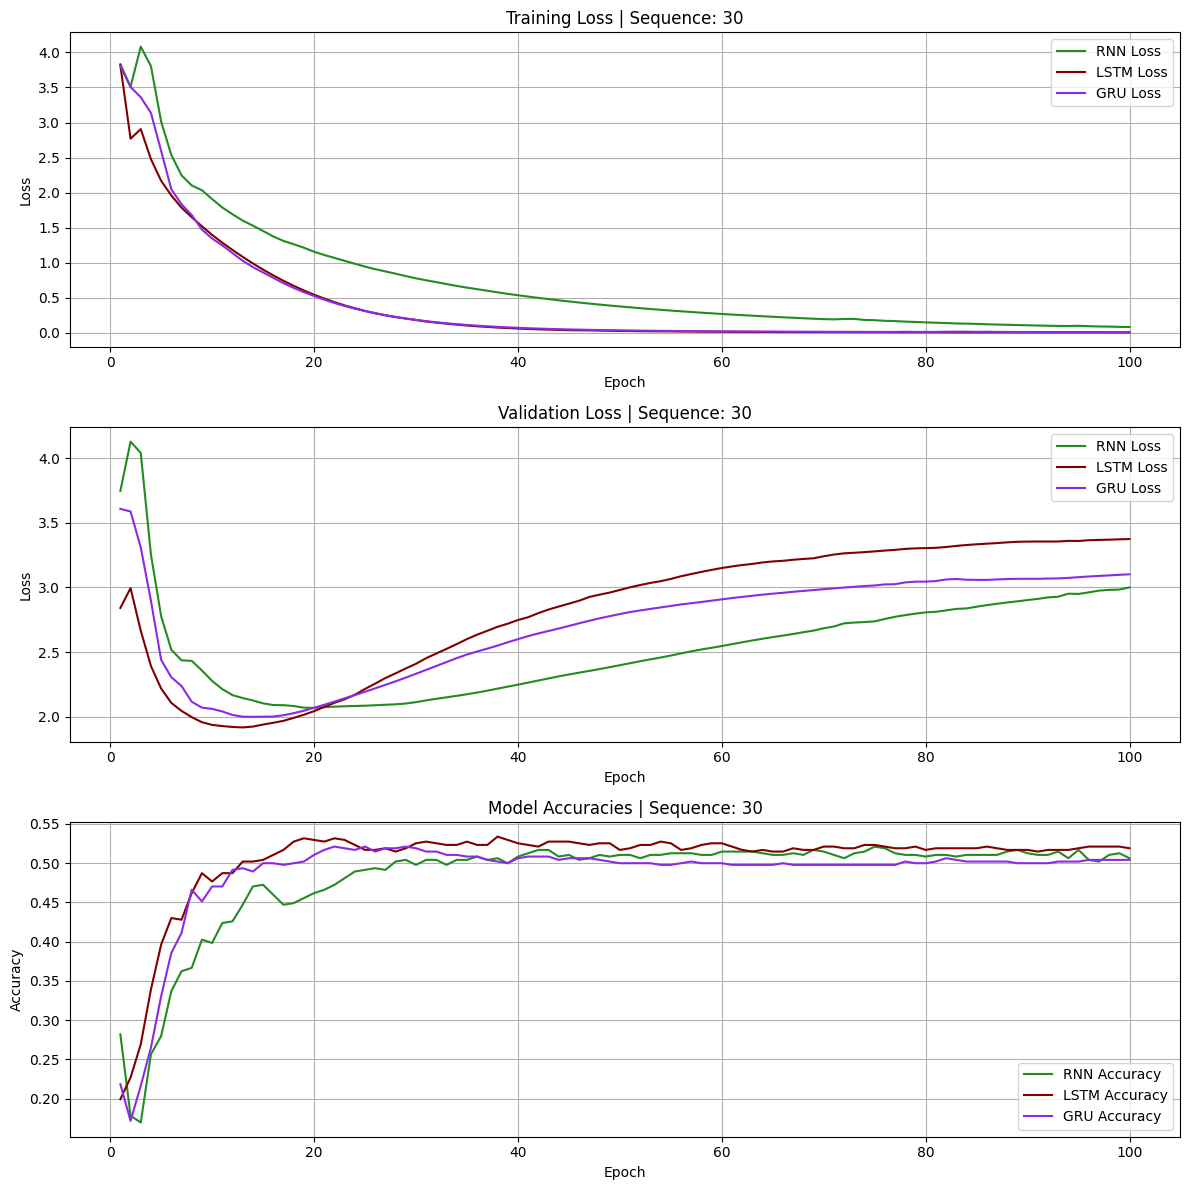

In [10]:
range_epochs = range(1, epochs+1)

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(range_epochs, RNN_train_loss, label='RNN Loss', color = 'forestgreen')
plt.plot(range_epochs, LSTM_train_loss, label='LSTM Loss', color = 'maroon')
plt.plot(range_epochs, GRU_train_loss, label='GRU Loss', color = 'blueviolet')
plt.title('Training Loss | Sequence: 30')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 1, 2)
plt.plot(range_epochs, RNN_val_loss, label='RNN Loss', color = 'forestgreen')
plt.plot(range_epochs, LSTM_val_loss, label='LSTM Loss', color = 'maroon')
plt.plot(range_epochs, GRU_val_loss, label='GRU Loss', color = 'blueviolet')
plt.title('Validation Loss | Sequence: 30')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 1, 3)
plt.plot(range_epochs, RNN_val_acc, label='RNN Accuracy', color = 'forestgreen')
plt.plot(range_epochs, LSTM_val_acc, label='LSTM Accuracy', color = 'maroon')
plt.plot(range_epochs, GRU_val_acc, label='GRU Accuracy', color = 'blueviolet')
plt.title('Model Accuracies | Sequence: 30')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()

plt.savefig('ResultsS30.png')